In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler, test_ensemble
from utils.test_results import TestResults
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Experiments

All models were trained on fold 2 of the AD-DC data

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)

# IMPORTANT - THE FOLD WE'RE USING FOR TESTING. NOTE: Training and testing fold should be the same
# we raise an error in the test_ensemble method if this is not the case!
TEST_FOLD = 2

# baseline: 
# exp_base = {2: "20180328_10_53_16_dcnnv1_150000E_lr2e02",
#            0: "20180330_09_56_39_dcnnv1_150000E_lr2e02"}
# exp_base_path = os.path.join(LOG_DIR, exp_base[TEST_FOLD])


exp_mc005_brier = {3: "20180428_09_11_35_dcnn_mc_f3p005_brier_150KE_lr2e02",
                   2: "20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02",
                   1: "20180426_14_45_50_dcnn_mc_f1p005_brier_150KE_lr2e02",
                   0: "20180418_15_02_36_dcnn_mcv1_150000E_lr2e02"}
exp_mc005_brier_path = os.path.join(LOG_DIR, exp_mc005_brier[TEST_FOLD])


exp_mc01_brier_results = {0: "test_results_25imgs_fold0_04_19_17_27.dll",
                          1: "",
                          2: "",
                          3: ""}
exp_mc01_brier = {3: "20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02",
                  2: "20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02",
                  1: "20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02",
                  0: "20180418_15_02_05_dcnn_mcv1_150000E_lr2e02"}
exp_mc01_brier_path = os.path.join(LOG_DIR, exp_mc01_brier[TEST_FOLD])



## Load experimental data and test data set

In [3]:
print("!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD {}".format(TEST_FOLD))

exper_mc005_brier = ExperimentHandler.load_experiment(exp_mc005_brier_path)
exper_hdl_mc005_brier = ExperimentHandler(exper_mc005_brier, use_logfile=False)
exper_hdl_mc005_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc005_brier.set_model_name("MC-dropout-brier fold-{} (p={})".format(
                                     exper_hdl_mc005_brier.exper.run_args.fold_ids[0],
                                     exper_hdl_mc005_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc005_brier.exper.model_name))


exper_mc01_brier = ExperimentHandler.load_experiment(exp_mc01_brier_path)
exper_hdl_mc01_brier = ExperimentHandler(exper_mc01_brier, use_logfile=False)
exper_hdl_mc01_brier.set_root_dir(ROOT_DIR)
exper_hdl_mc01_brier.set_model_name("MC-dropout brier fold-{} (p={})".format(
                                exper_hdl_mc01_brier.exper.run_args.fold_ids[0],
                                exper_hdl_mc01_brier.exper.run_args.drop_prob))
print("Model name {}".format(exper_hdl_mc01_brier.exper.model_name))


try:
    del test_set
except:
    pass

test_set = ACDC2017TestHandler(exper_config=exper_hdl_mc005_brier.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[TEST_FOLD],
                               debug=False, batch_size=25, use_cuda=True, load_train=False, load_val=True,
                               use_iso_path=True)

  0%|          | 0/25 [00:00<?, ?it/s]

!!! IMPORTANT !!! - EVALUATING MODELS ON HOLD OUT IMAGES IN FOLD 2
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_47_23_dcnn_mc_f2p005_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout-brier fold-2 (p=0.05)
Load experiment from /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
Model name MC-dropout brier fold-2 (p=0.1)
INFO - Testhandler - >>> Search in val-dir for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/validate/images_iso/*patient*.mhd <<<
INFO - File list contains 50 files, hence 25 patients


100%|██████████| 25/25 [00:01<00:00, 16.29it/s]

INFO - Successfully loaded 25 ED/ES patient pairs


## Run model evaluation of test set

In [4]:
mc_samples = 10
sample_weights = True
store_details = True
image_range =  [9] # [0, 9, 22] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = False
referral_threshold = 0.
ref_positives_only = False
# if not sample_weights & save_pred_labels => we save pred_labels & referred_pred_labels
save_filtered_umaps = False
save_pred_labels = False

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_filtered_umaps=save_filtered_umaps, save_pred_labels=save_pred_labels)


    
print("Ready")

Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 1 images with model from checkpoint 150000
Image 10-patient030 - test loss -1.049  dice(RV/Myo/LV):	ES 0.50/0.91/0.54	ED 0.81/0.87/0.82
					Hausdorff(RV/Myo/LV):	ES 24.57/12.76/33.48	ED 16.09/15.01/31.34
------------------------------------------------------------------------------------------------
Overall:	dice(RV/Myo/LV): ES 0.50 (0.00)/0.91 (0.00)/0.54 (0.00)	ED 0.81 (0.00)/0.87 (0.00)/0.82 (0.00)
Hausdorff(RV/Myo/LV):	ES 24.57 (0.00)/12.76 (0.00)/33.48 (0.00)	ED 16.09 (0.00)/15.01 (0.00)/31.34 (0.00)
INFO - generating statistics for 1 run(s). May take a while
Ready


In [52]:
mc_samples = 1
sample_weights = False
store_details = False
image_range = None # [9] # [10, 24] #  [24]
if sample_weights:
    generate_stats = True
else:
    generate_stats = False
save_results = False
checkpoints = [150000]  #  [150000]  [130000, 140000, 150000]
use_uncertainty = True
referral_threshold = 0.14
ref_positives_only = True
save_filtered_umaps = False
save_pred_labels = True

exper_handler = exper_hdl_mc01_brier

exper_handler.logger = None   # exper_hdl_base
exper_handler.exper.outliers_per_epoch = None

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=use_uncertainty, referral_threshold=referral_threshold, image_range=image_range, 
              checkpoints=checkpoints, ref_positives_only=ref_positives_only,
              verbose=False, reset_results=True, store_details=store_details, 
              generate_stats=generate_stats, save_results=save_results, do_filter=True,
              save_filtered_umaps=save_filtered_umaps, save_pred_labels=save_pred_labels)


    
print("Ready")

WARNING - Using uncertainty maps to refer pixels. Threshold 0.14
Loading existing model loaded from checkpoint dir /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/checkpoints
Evaluating model MC-dropout brier fold-2 (p=0.1) - runID 1
INFO - Running test on 25 images with model from checkpoint 150000
('Shape of u-maps/ref-mask ', (2, 291, 321, 11), (2, 291, 321, 11))
Slice 1 ES Class 1: errors 0 #true_pos 0 #pos_labels 0 #u-pixels 0 #pos+unc-pixels 0
Slice 1 ED Class 1: errors 19 #true_pos 0 #pos_labels 19 #u-pixels 19 #pos+unc-pixels 19
Ref% ES/ED 50.26/42.41 - #Errors before/after reduction ES: 10895.0/3564.0 ED: 11319.0/5712.0
Image 1-patient006 - test loss -2.687  dice(RV/Myo/LV):	ES 0.74/0.80/0.95	ED 0.84/0.75/0.95
					 After referral		ES 0.95/0.90/0.96	ED 0.93/0.85/0.96
					Hausdorff(RV/Myo/LV):	ES 22.66/32.47/10.10	ED 21.87/33.83/10.93
					After referral:		ES 13.13/24.81/10.00	ED 21.87/21.32/10.93
('Shape of u-maps/ref-mask ', (2, 297, 3

('Shape of u-maps/ref-mask ', (2, 250, 211, 7), (2, 250, 211, 7))
Slice 1 ES Class 1: errors 0 #true_pos 0 #pos_labels 0 #u-pixels 0 #pos+unc-pixels 0
Slice 1 ED Class 1: errors 1077 #true_pos 0 #pos_labels 1077 #u-pixels 838 #pos+unc-pixels 838
Ref% ES/ED 21.71/26.65 - #Errors before/after reduction ES: 1893.0/1292.0 ED: 5845.0/2752.0
Image 14-patient049 - test loss -2.521  dice(RV/Myo/LV):	ES 0.73/0.88/0.96	ED 0.66/0.79/0.88
					 After referral		ES 0.77/0.92/0.97	ED 0.83/0.87/0.94
					Hausdorff(RV/Myo/LV):	ES 14.21/8.85/3.96	ED 38.21/23.26/28.42
					After referral:		ES 14.21/5.60/3.96	ED 37.70/16.33/23.26
('Shape of u-maps/ref-mask ', (2, 242, 250, 10), (2, 242, 250, 10))
Slice 1 ES Class 1: errors 0 #true_pos 0 #pos_labels 0 #u-pixels 0 #pos+unc-pixels 0
Slice 1 ED Class 1: errors 272 #true_pos 0 #pos_labels 272 #u-pixels 241 #pos+unc-pixels 241
Ref% ES/ED 25.54/17.67 - #Errors before/after reduction ES: 4253.0/3029.0 ED: 4068.0/2869.0
Image 15-patient050 - test loss -1.982  dice

In [ ]:
exper_hdl_mc01_brier.create_filtered_umaps(u_threshold=0.14, verbose=True)
print("Ready")

In [ ]:
exper_handler = exper_hdl_mc005_brier

# image_ids = exper_handler.test_results.image_ids

image_range = None
u_type = "stddev"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=True, u_type=u_type,
               use_saved_umaps=True)

# Compare performance of models

In [9]:
image_range = [24]

for img_idx in image_range:
    exper_handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="probs",
                                                     do_save=True, do_show=False,
                                                     model_name=exper_handler.exper.model_name)

ES correct/error(fp+fn) (447353,) / (7519,)
ED correct/error(fp+fn) (441197,) / (7837,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180416_08_25_43_dcnn_mcv1_150000E_lr2e02/figures/patient100/probs_densities_mc5_False.png


Found label file /home/jorg/repository/dcnn_acdc/logs/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/pred_lbls/patient030_filtered_pred_labels0_14.npz
[4526 2052 1353 1266 1795 1427 1510 2318 2125 5323]
Rows/columns/height 18/4/80


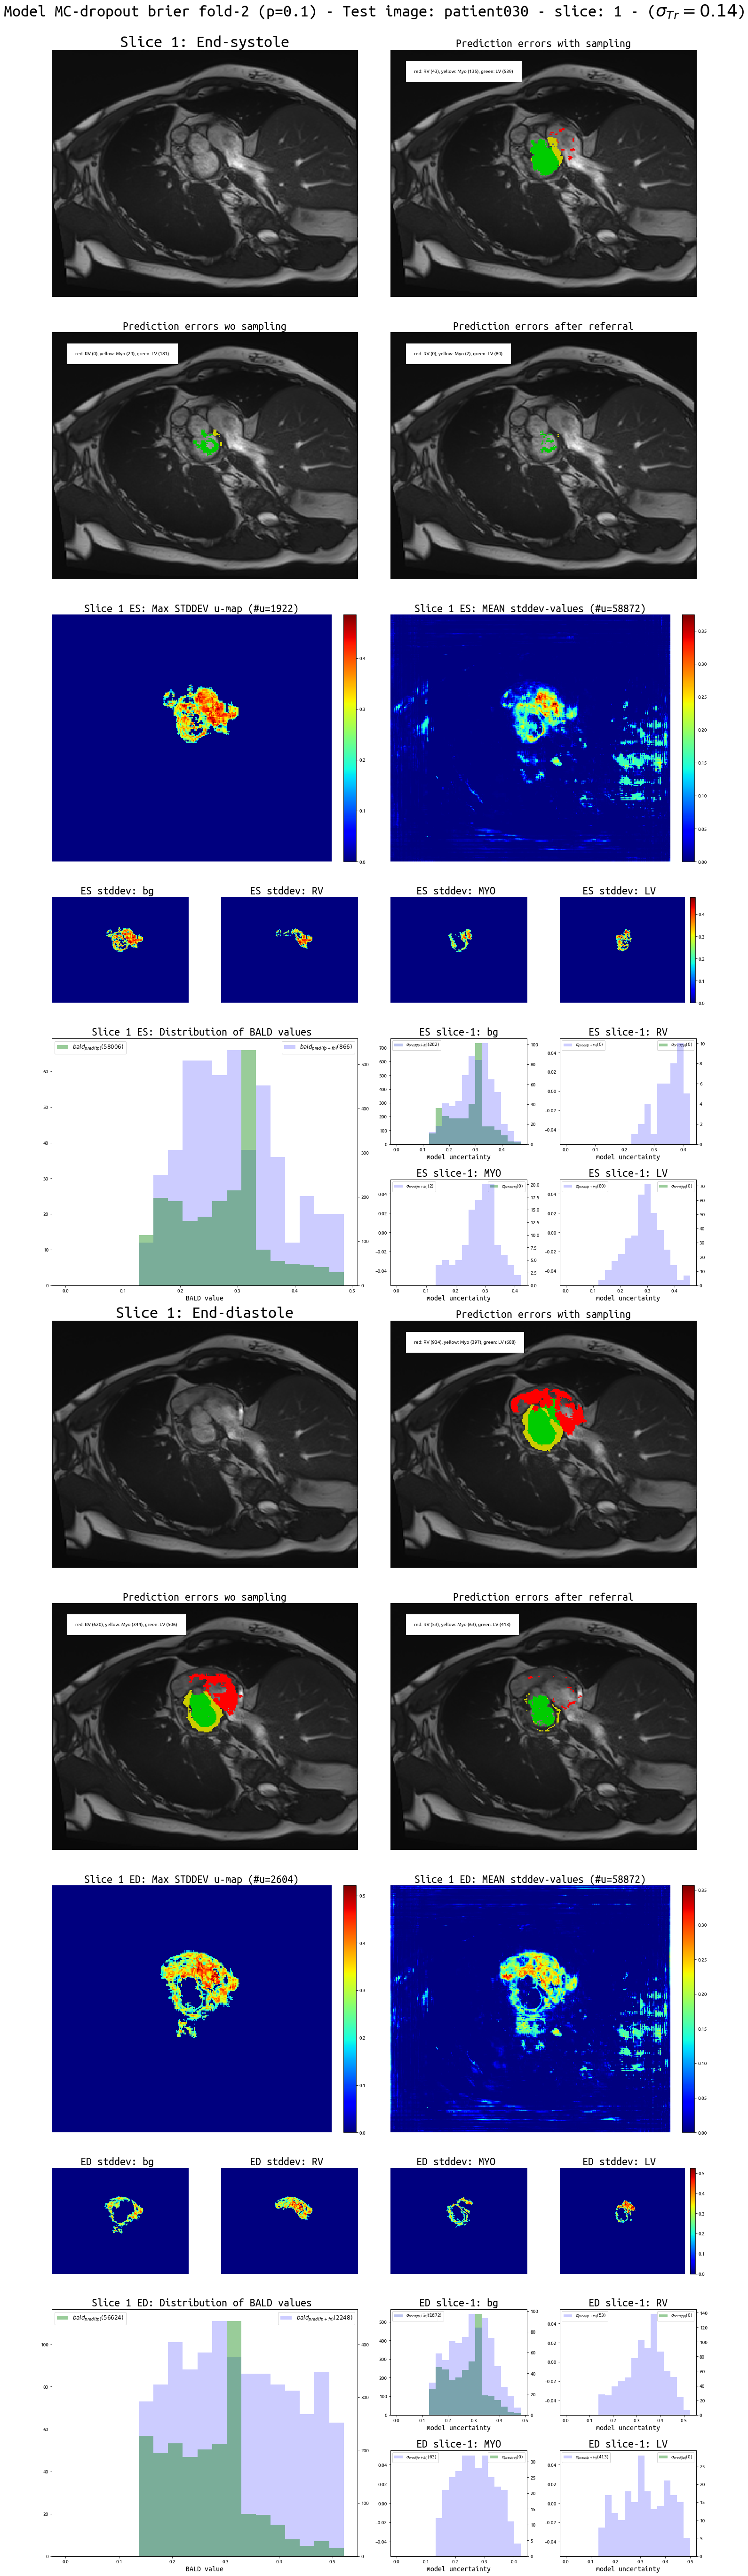

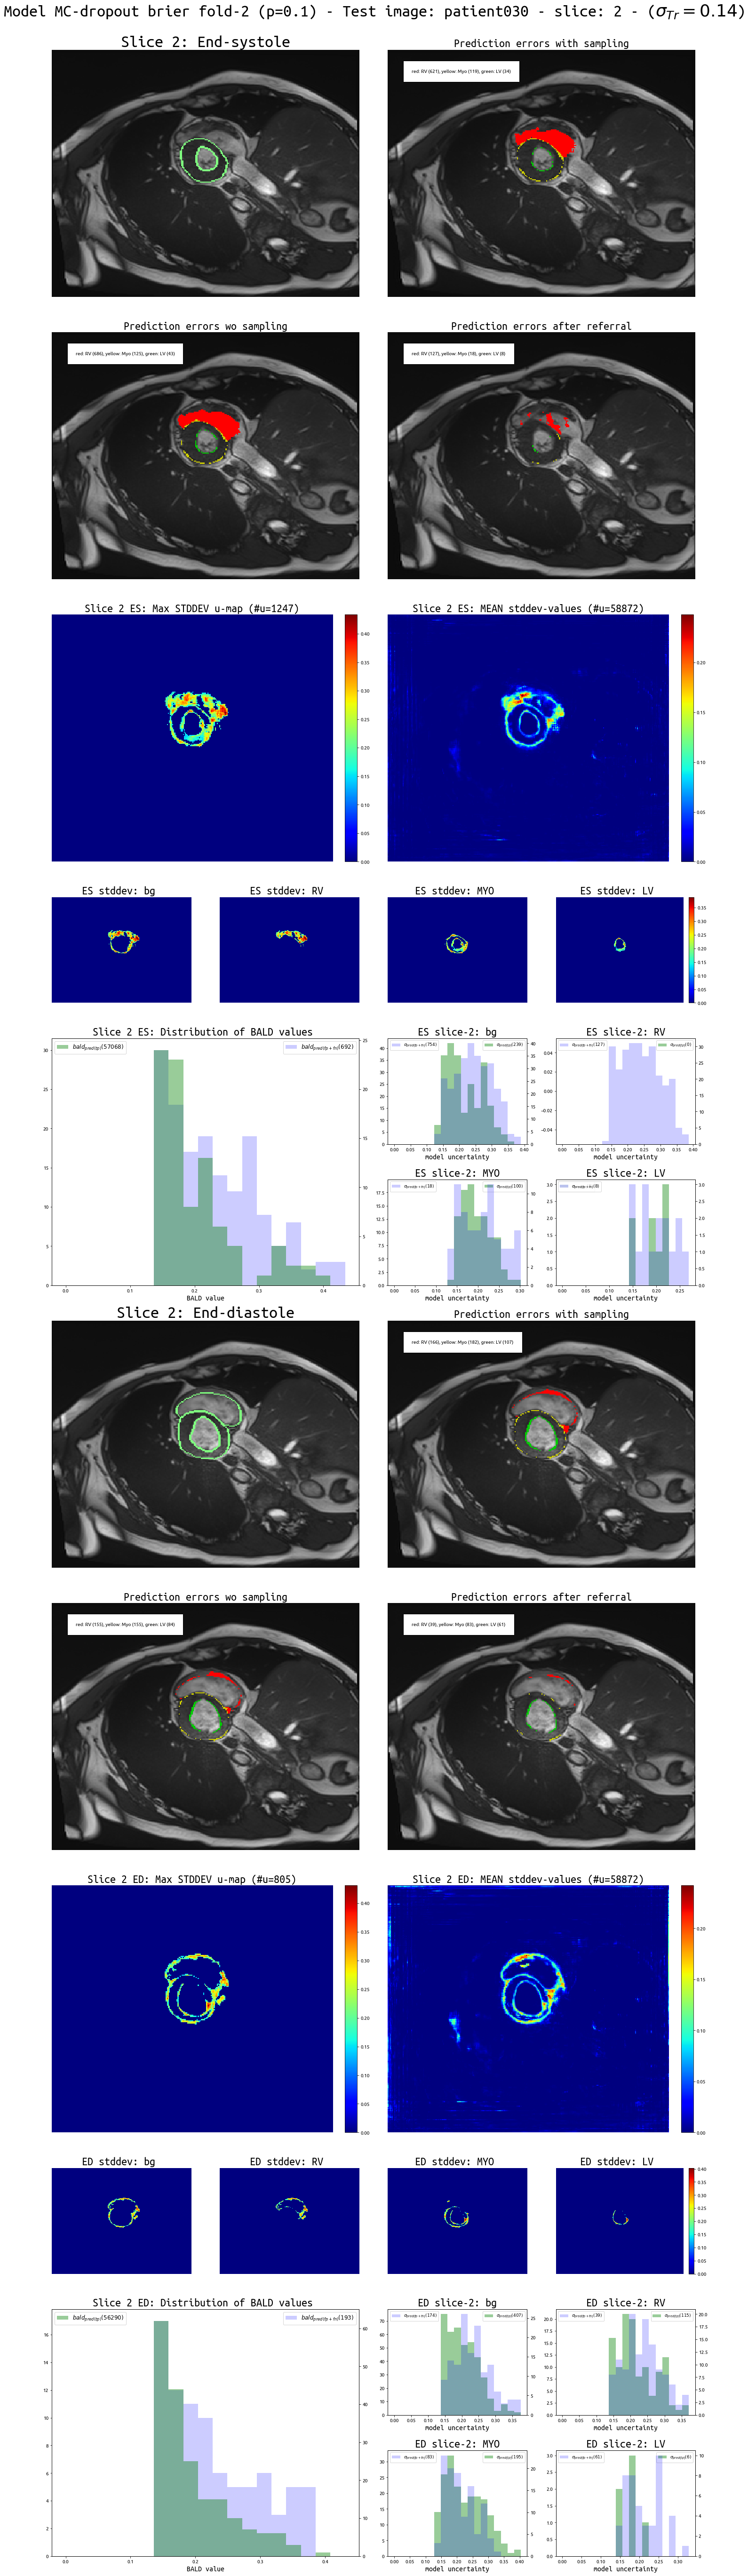

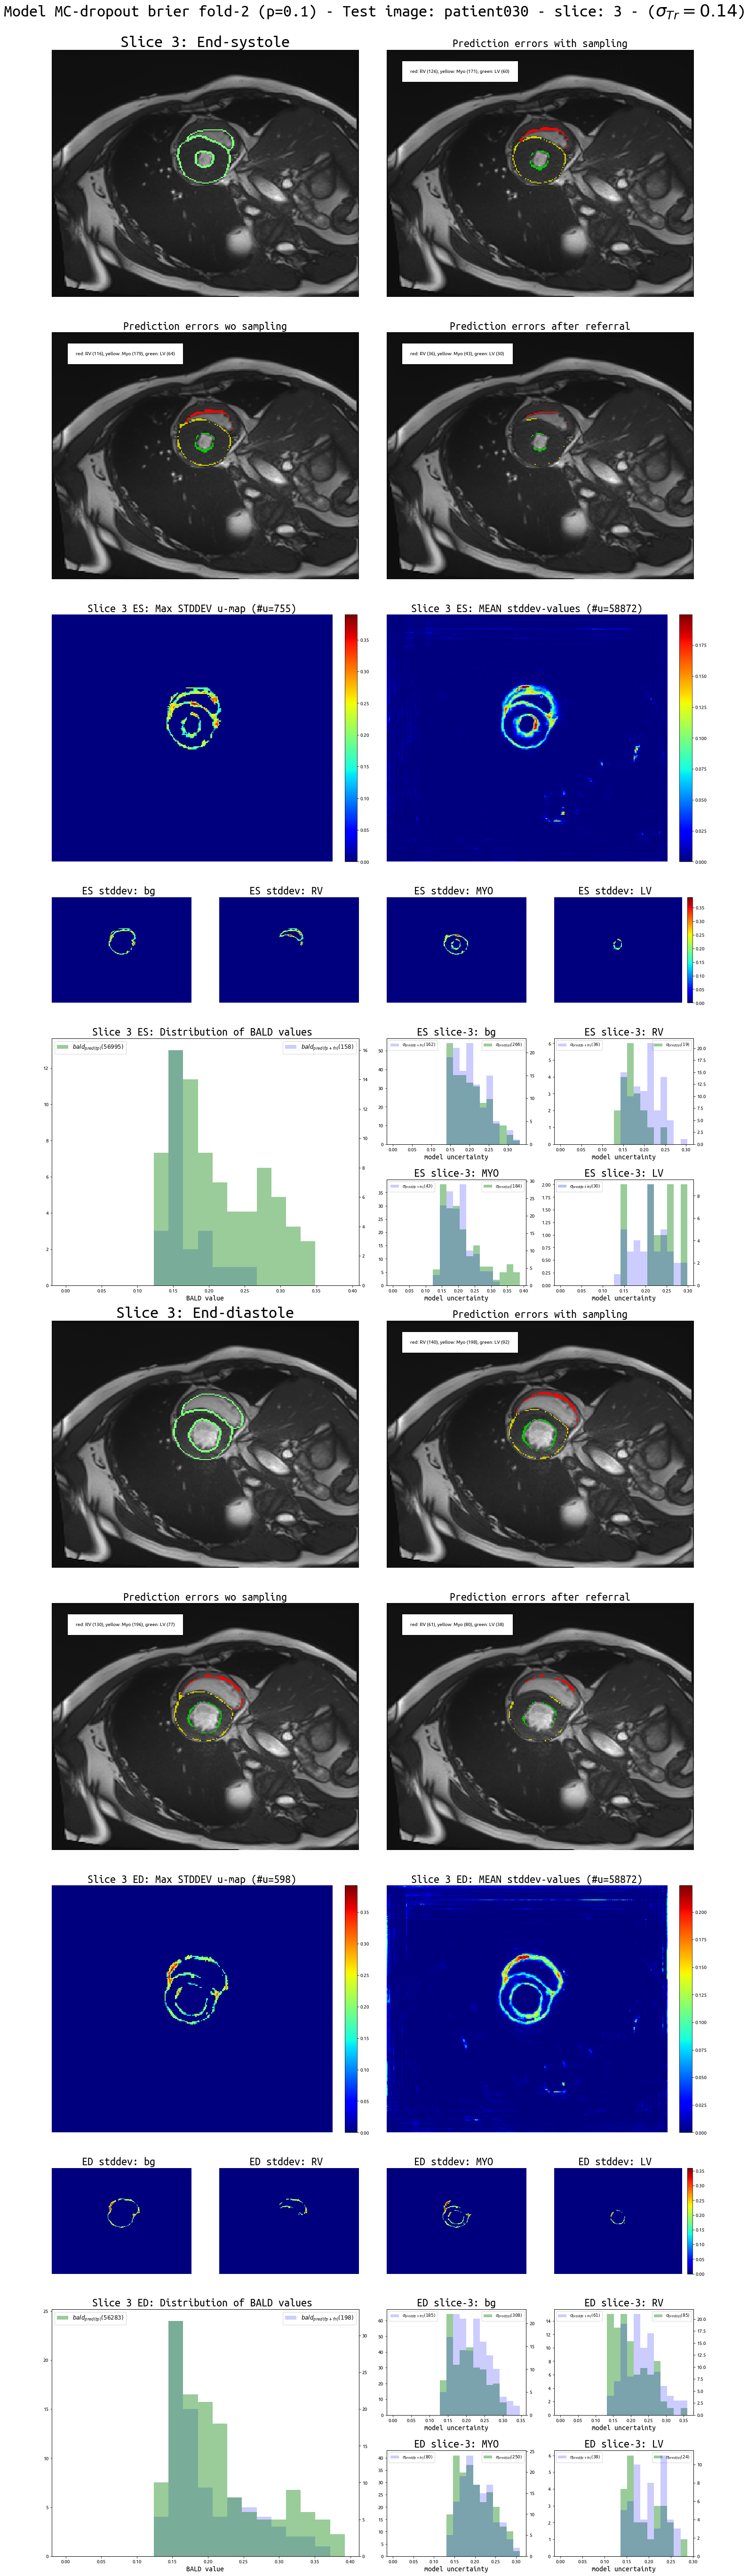

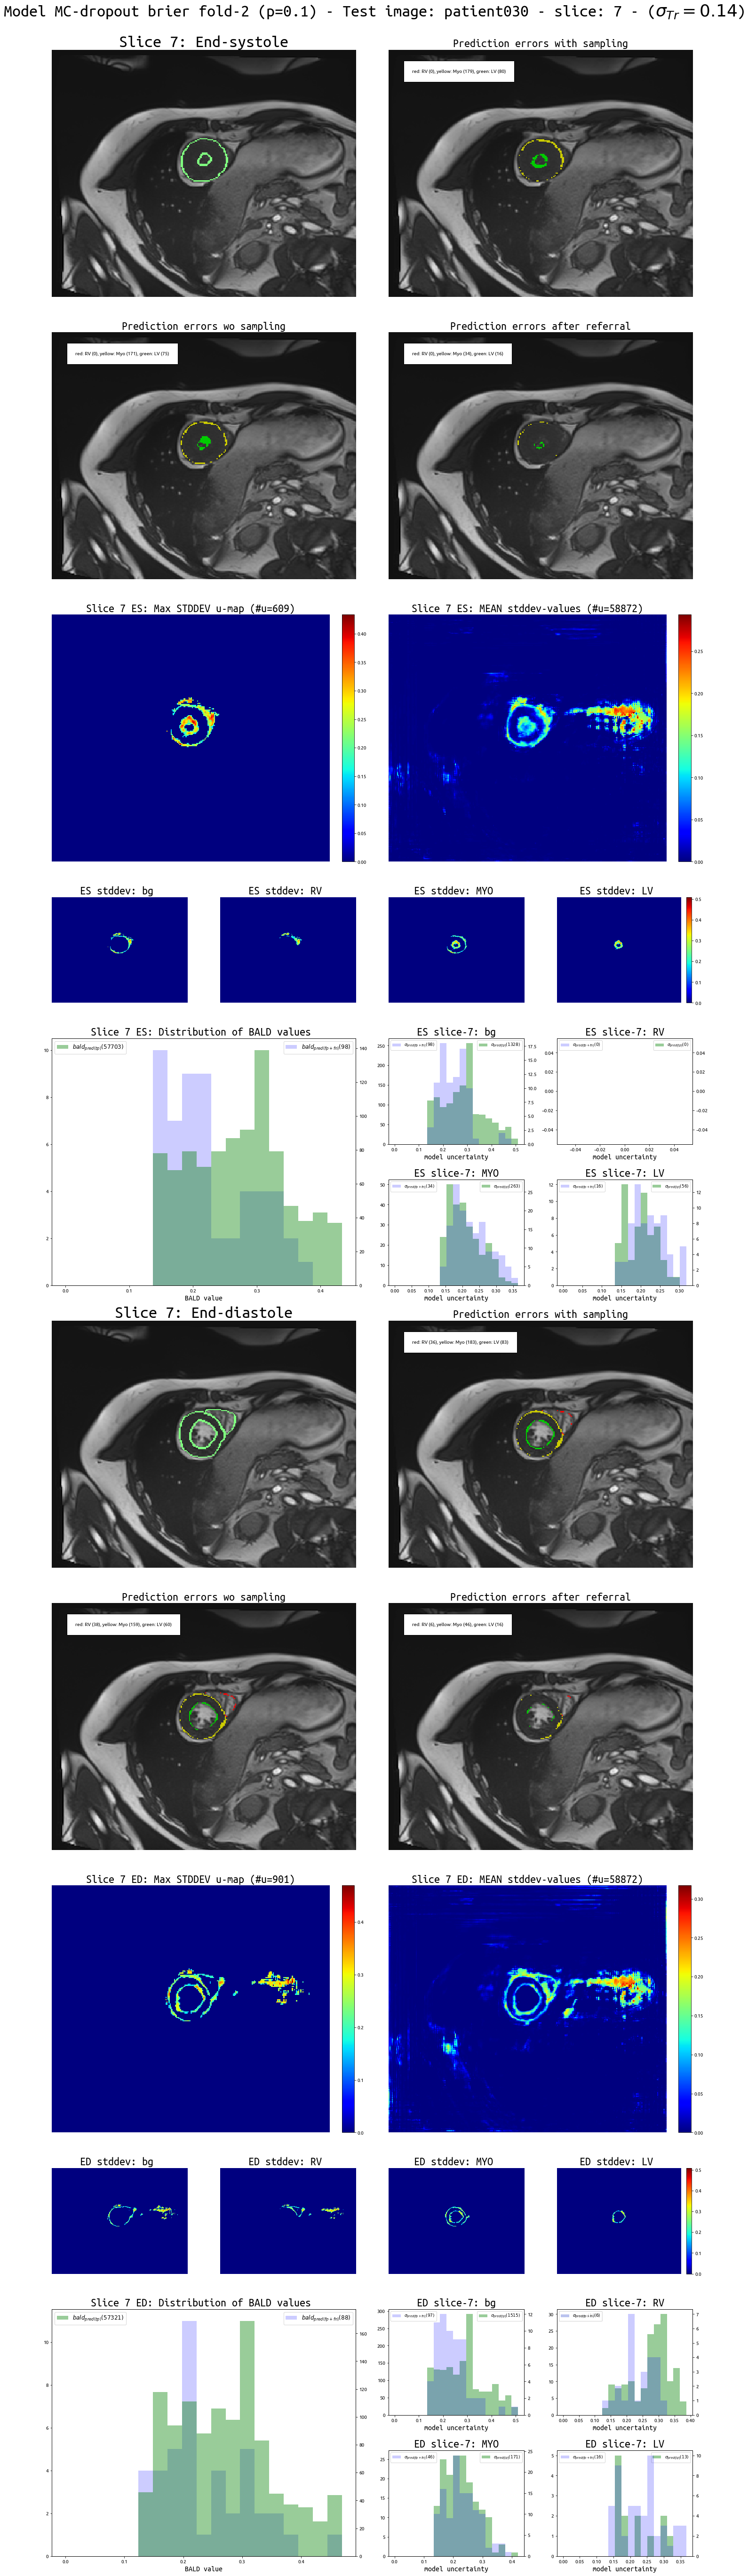

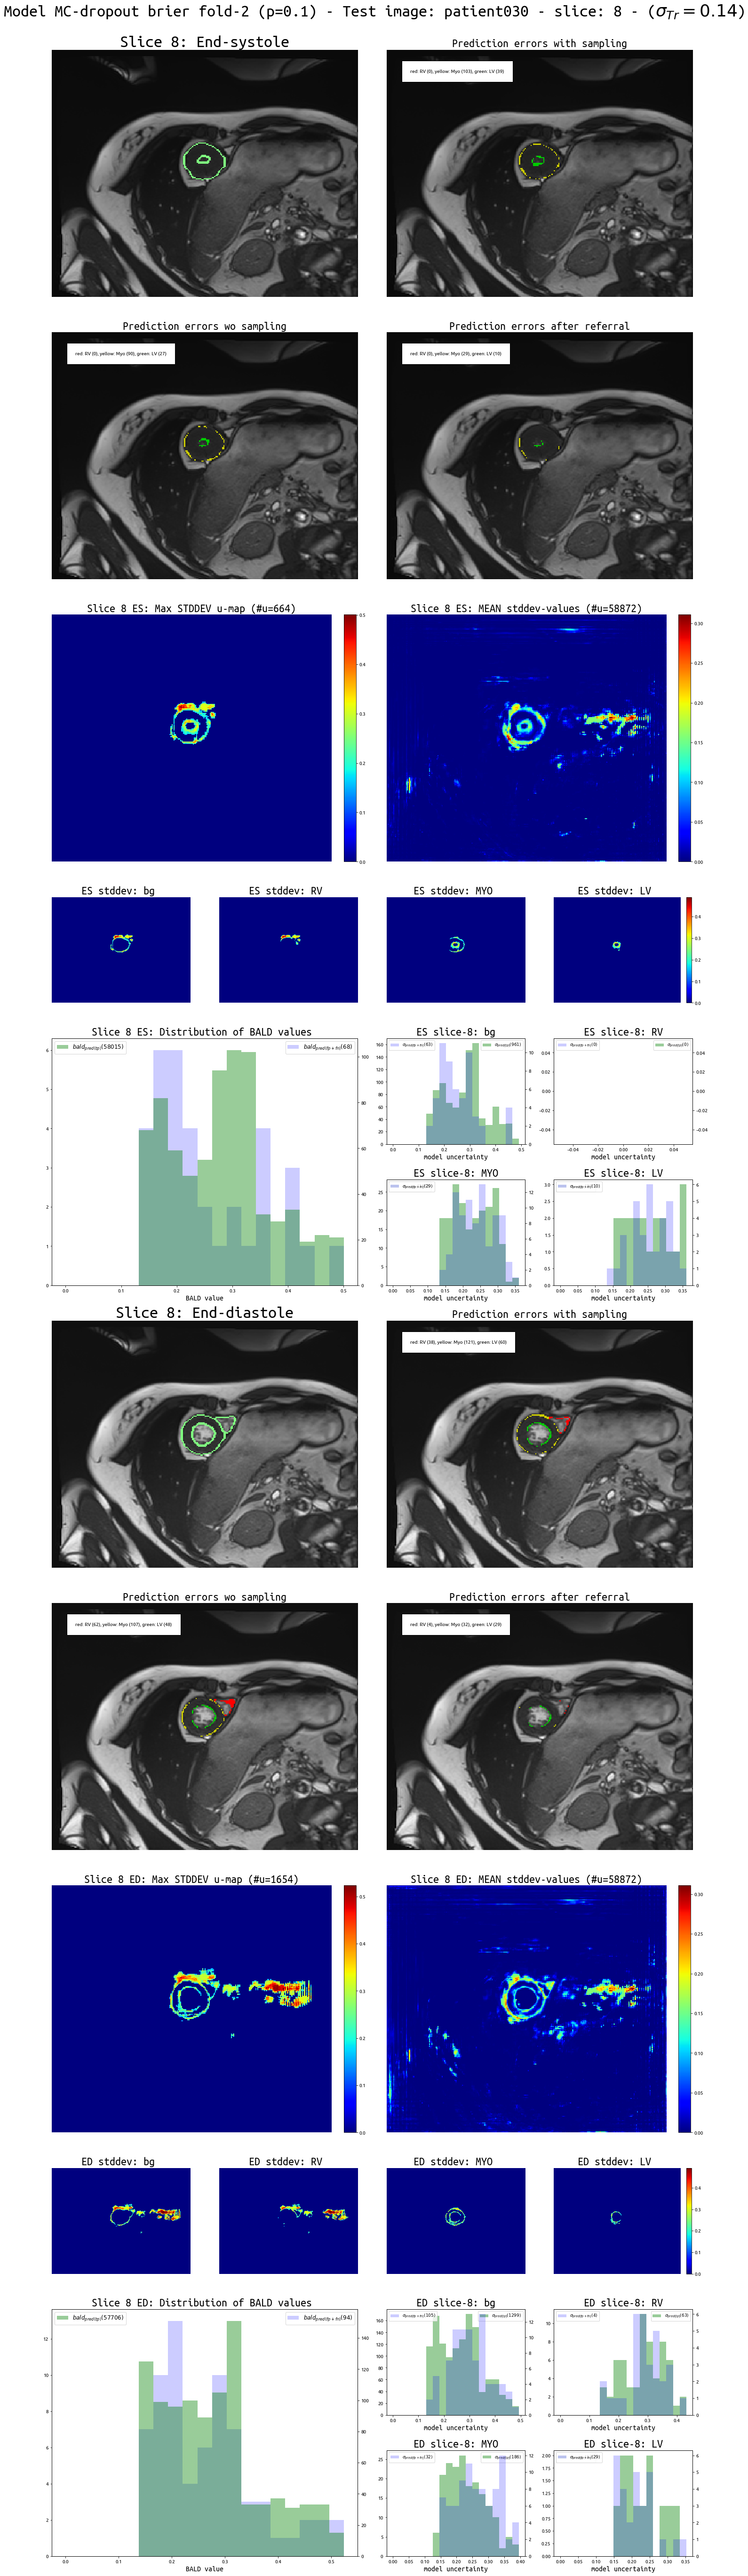

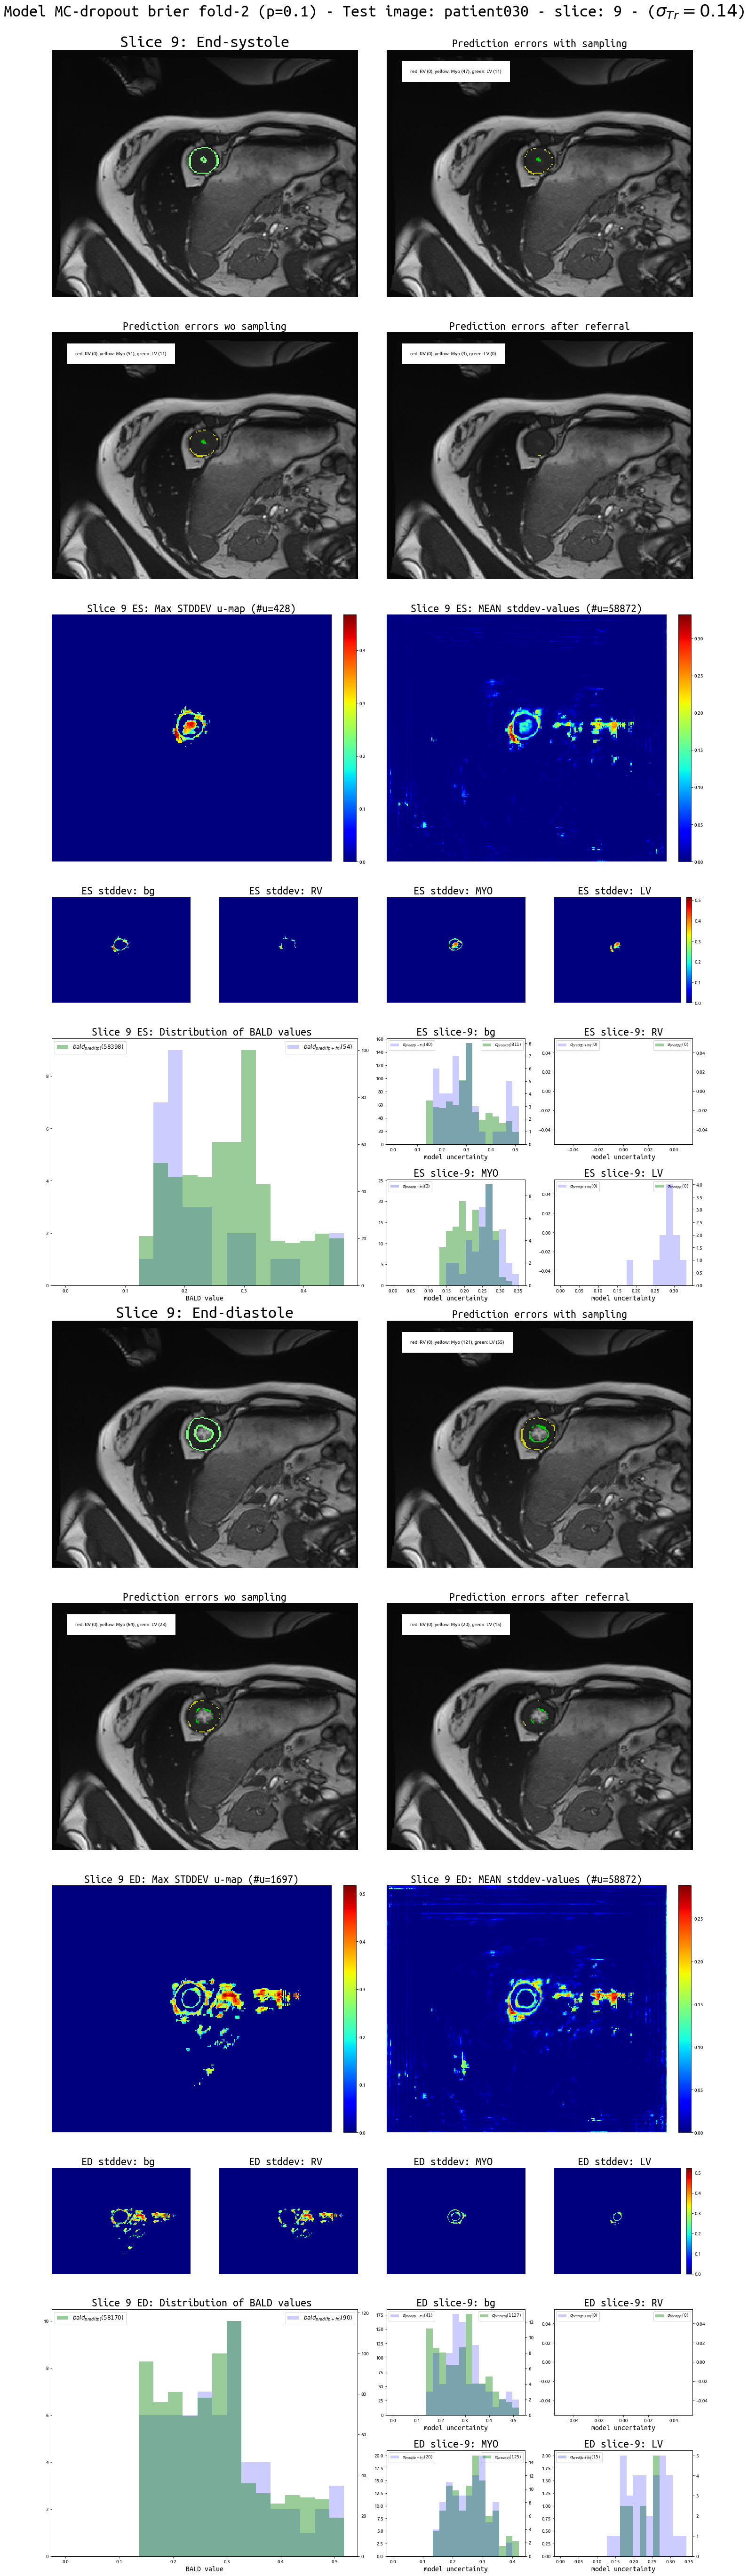

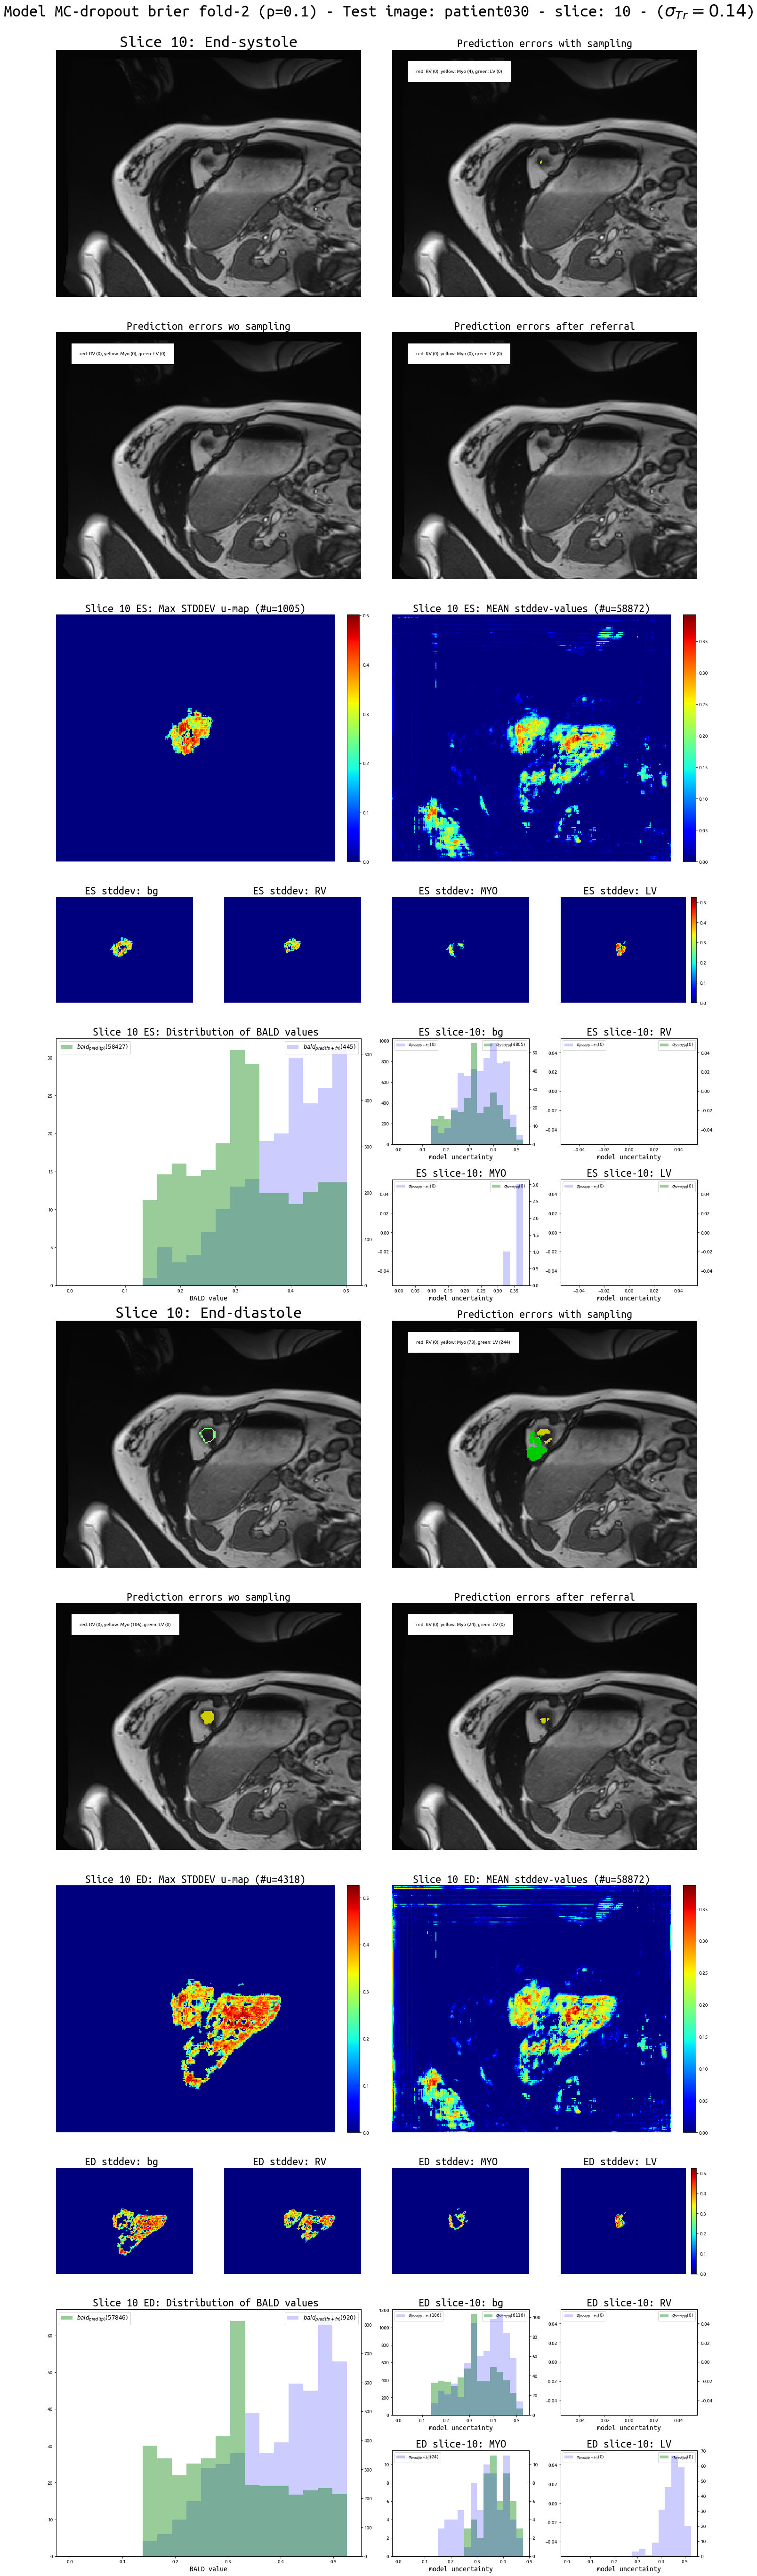

INFO - Ready!


In [51]:
# model_name a) Baseline  b) MC-dropout 0.1

model_name = exper_handler.exper.model_name
errors_only = False  # in case of the BASELINE model we only want the seg-errors
plot_detailed_hists = True
image_range = [9]
if image_range is None:
    image_range = np.arange(len(exper_handler.test_results.image_names))


for image_num in image_range:
    exper_handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                                 info_type="uncertainty",
                                                                 do_save=False, slice_range=[0, 1, 2, 6, 7,8,9],
                                                                 std_threshold=0.14, errors_only=errors_only, 
                                                                 do_show=True, use_bald=True,
                                                                 model_name = model_name,
                                                                 plot_detailed_hists=plot_detailed_hists,
                                                                 load_referral=True, ref_positives_only=False)
                                                                 # uncertainty
    print("INFO - Ready!")


going to refer 0 pixels of 1144
U-map max 0.43 & #uncertain-pixels 0


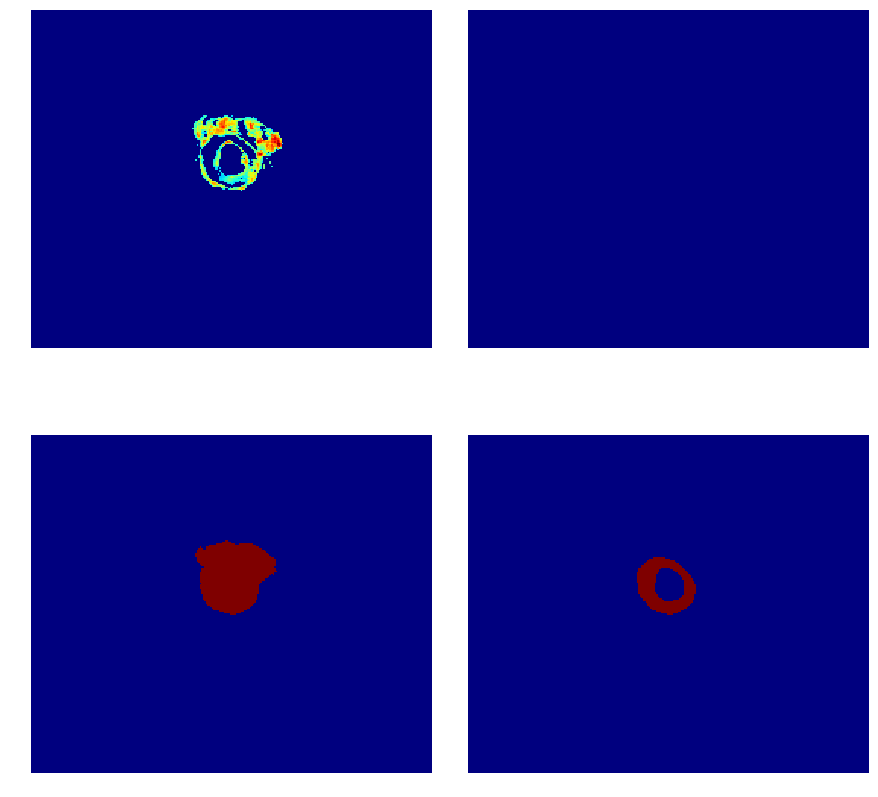

In [42]:
import copy

def create_mask_uncertainties(labels):
    # assuming labels has shape [8classes, width, height, with or without slices]
    num_of_classes = labels.shape[0] / 2
    
    # first flip background labels
    cp_labels = copy.deepcopy(labels)
    for phase in range(2):
        # cls_offset = phase * num_of_classes
        # bg0 = cp_labels[0 + cls_offset] == 0
        # bg1 = cp_labels[0 + cls_offset] == 1
        # print("1. In function ", np.count_nonzero(bg0), np.count_nonzero(bg1))
        # cp_labels[0 + cls_offset][bg0] = 1
        # cp_labels[0 + cls_offset][bg1] = 0

        if phase == 0:
            mask_es = np.sum(cp_labels[1:num_of_classes], axis=0) == 0
        else:
            mask_ed = np.sum(cp_labels[num_of_classes +1:], axis=0) == 0
        
    del cp_labels
    return np.concatenate((np.expand_dims(mask_es, axis=0), np.expand_dims(mask_ed, axis=0))).astype(np.bool)

exper_handler = exper_hdl_mc01_brier
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.u_map_dir))
pred_lbl_input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, 
                                                        config.pred_lbl_dir))
file_name_lbl = os.path.join(pred_lbl_input_dir, "patient030_pred_labels.npz")

file_name = os.path.join(input_dir, "patient030_filtered_umaps0_14.npz")

file_name_ref_lbl = os.path.join(pred_lbl_input_dir, "patient030_filtered_pred_labels0_14_pos_only.npz")

data = np.load(file_name)
data_lbl = np.load(file_name_lbl)
data_ref_lbl = np.load(file_name_ref_lbl)
u_map = data["filtered_umap"]
u_map_es = u_map[0]
pred_labels = data_lbl["filtered_pred_label"]
ref_lbl_myo = data_ref_lbl["filtered_pred_label"]
# overall_mask = create_mask_uncertainties(pred_labels)
img_slice = 1
# overall_mask_slice_es = overall_mask[0, :, :, img_slice]
u_map_slice = u_map_es[:, :, img_slice]
u_map_slice_pos_only = copy.deepcopy(u_map_slice)

true_labels_slice = copy.deepcopy(exper_handler.test_results.labels[0][1:4, :, :, img_slice])
pred_labels_slice = pred_labels[0:4, :, :, img_slice]
pred_labels_slice_es = np.sum(pred_labels_slice, axis=0)
ref_pred_labels_slice_es = ref_lbl_myo[2, :, :, img_slice]
overall_mask = create_mask_uncertainties(pred_labels_slice)
overall_mask_slice_es = overall_mask[0]
u_map_slice_pos_only[overall_mask_slice_es] = 0
high_unc_pixels = u_map_slice_pos_only != 0

# IMPORTANT HERE
print("going to refer {} pixels of {}".format(np.count_nonzero(high_unc_pixels),
                                              np.count_nonzero(true_labels_slice)))


u_map_max = np.max(u_map_slice)
print("U-map max {:.2f} & #uncertain-pixels {}".format(u_map_max, np.count_nonzero(u_map_slice_pos_only)))
# u_map_slice[u_map_slice < 0.4] = 0
fig = plt.figure(figsize=(15, 15))
ax4plot = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(u_map_slice_pos_only, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=2)
ax4plot = plt.imshow(pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
ax4plot = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2)
ax4plot = plt.imshow(ref_pred_labels_slice_es, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")

plt.show()

del u_map
del u_map_es
del u_map_slice

(4, 297, 300)
After max  (297, 300)
U-map max 0.73
595


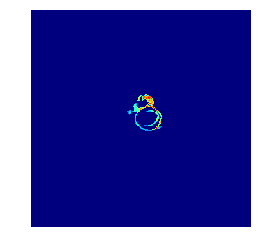

In [58]:
input_dir = os.path.join(exper_handler.exper.config.root_dir,
                                           os.path.join(exper_handler.exper.output_dir, config.u_map_dir))
file_name = os.path.join(input_dir, "patient007_filtered_cls_umaps0_14.npz")
data = np.load(file_name)
u_map = data["filtered_cls_umap"]
u_map_es = u_map[:4]
img_slice = 9
u_map_slice = u_map_es[:, :, :, img_slice]
print(u_map_slice.shape)
u_map_slice = np.sum(u_map_slice, axis=0)
print("After max ", u_map_slice.shape)
u_map_max = np.max(u_map_slice)
print("U-map max {:.2f}".format(u_map_max))
print(np.count_nonzero(u_map_slice[u_map_slice >= 0.14]))
ax4plot = plt.imshow(u_map_slice, cmap=plt.get_cmap('jet'), vmin=0., vmax=u_map_max)
plt.axis("off")
plt.show()
del u_map
del u_map_es
del u_map_slice

In [133]:
from skimage import data, segmentation
from skimage import exposure
# gb_error_codes = [[], [255, 0, 0], [204, 204, 0], [0, 204, 0]]

img_es = exper_handler.test_results.images[0][0, :, :, 2]
mask = np.zeros_like(img_es)
rv_lbls = exper_handler.test_results.labels[0][1, :, :, 2]
mask[rv_lbls == 1] = 1
myo_lbls = exper_handler.test_results.labels[0][2, :, :, 2]
mask[myo_lbls == 1] = 2
lv_lbls = exper_handler.test_results.labels[0][3, :, :, 2]
mask[lv_lbls == 1] = 3
img_es = exposure.rescale_intensity(img_es)
clean_border = segmentation.clear_border(mask).astype(np.int)
img_lbl = segmentation.mark_boundaries(img_es, clean_border, mode="outer", color=(0, 1, 0), 
                                       background_label=0)
img_lbl = exposure.rescale_intensity(img_lbl, out_range=(0, 1))

(-0.5, 299.5, 261.5, -0.5)

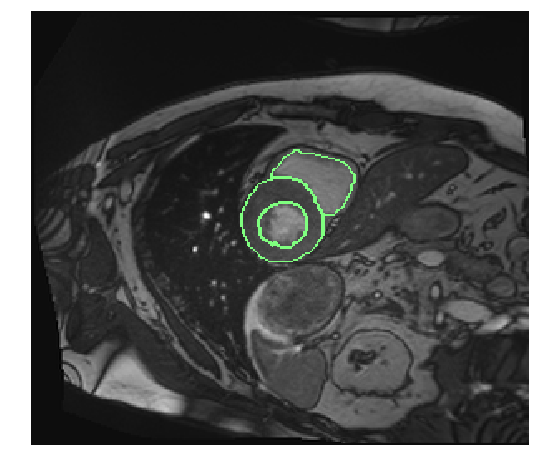

In [135]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=2)
ax1.imshow(img_lbl)
plt.axis('off')

In [4]:
exper_handler = exper_hdl_mc01_brier
dataset = ACDC2017DataSet(exper_handler.exper.config, search_mask=config.dflt_image_name + ".mhd",
                              fold_ids=exper_handler.exper.run_args.fold_ids, preprocess=False,
                              debug=exper_handler.exper.run_args.quick_run, incomplete_only=True)
del dataset

  1%|▏         | 1/75 [00:00<00:11,  6.37it/s]

INFO - Using folds ['2'] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold2/train/images_iso/*patient*.mhd <<<


100%|██████████| 25/25 [00:01<00:00, 13.93it/s]

WARNING - Loading only images WITH INCOMPLETE slices (missing RV/MYO or LV)
INFO - Using folds ['2'] - loaded 200 files: 1876 slices in train set, 804 slices in validation set
INFO - Mean width/height/#slices per image 235/263/9
---------------------- Image incompleteness statistics -------------------------
ES: slices missing RV/MYO/LV 456/108/116 (0.68/0.16/0.17) / complete 194 wo-all 88
ED: slices missing RV/MYO/LV 639/244/312 (0.95/0.36/0.47) / complete 12 wo-all 227
